In [1]:
using Images
using PyPlot
using FileIO
using Optim
using Random
using Statistics

include("Common.jl")

Main.Common

In [2]:
#---------------------------------------------------------
# Load features and labels from file.
#---------------------------------------------------------
function loaddata(path::String)
    data = load(path)
    features = data["features"]
    labels = data["labels"]
  @assert length(labels) == size(features,1)
  return features::Array{Float64,2}, labels::Array{Float64,1}
end

features, labels = loaddata("separable.jld2")
features2, labels2 = loaddata("nonseparable.jld2")

([-0.594015 -1.41353; -1.64258 -0.39186; … ; 2.06773 0.0168081; 2.39037 0.0168081], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

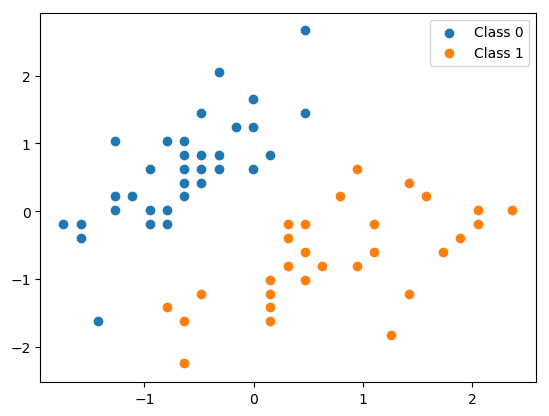

In [3]:
#---------------------------------------------------------
# Show a 2-dimensional plot for the given features with
# different colors according to the labels.
#---------------------------------------------------------
function showbefore(features::Array{Float64,2},labels::Array{Float64,1})
    PyPlot.figure()
    PyPlot.scatter(features[labels.==0,1], features[labels.==0,2], label="Class 0")
    PyPlot.scatter(features[labels.==1,1], features[labels.==1,2], label="Class 1")
    PyPlot.legend()
    PyPlot.show()
  return nothing::Nothing
end

showbefore(features, labels)

In [4]:
#---------------------------------------------------------
# Show a 2-dimensional plot for the given features along
# with the decision boundary.
#---------------------------------------------------------
function showafter(features::Array{Float64,2},labels::Array{Float64,1},Ws::Vector{Any}, bs::Vector{Any})
    #p, c = predict(features, Ws, bs)
    #c = reshape(c, length(c))
    
    PyPlot.figure()
    
    # plot data points with correct labels like before
    PyPlot.scatter(features[labels.==0,1], features[labels.==0,2], label="Class 0")
    PyPlot.scatter(features[labels.==1,1], features[labels.==1,2], label="Class 1")
    
    # get x and y ranges
    xmin, xmax = minimum(features[:,1]), maximum(features[:,1])
    ymin, ymax = minimum(features[:,2]), maximum(features[:,2])

    # make meshgrid
    x = xmin:0.01:xmax
    y = ymin:0.01:ymax
    xx, yy = Common.meshgrid(x, y)

    # compute prediction for all points in meshgrid
    p, z = predict([xx[:] yy[:]], Ws, bs)
    # do contour plot where class probability is 0.5
    PyPlot.contour(xx, yy, reshape(p, size(xx)), [0.5], label="Decision boundary")
    PyPlot.legend()
    PyPlot.show()
  return nothing::Nothing
end

showafter (generic function with 1 method)

In [5]:
#---------------------------------------------------------
# Implements the sigmoid function.
#---------------------------------------------------------
function sigmoid(z)
    s = 1.0 ./ (1.0 .+ exp.(-z))
  return s
end

#---------------------------------------------------------
# Implements the derivative of the sigmoid function.
#---------------------------------------------------------
function dsigmoid_dz(z)
    ds = sigmoid(z) .* (1 .- sigmoid(z))
  return ds
end


dsigmoid_dz (generic function with 1 method)

In [6]:
#---------------------------------------------------------
# Evaluates the loss function of the MLP.
#---------------------------------------------------------
function nnloss(theta::Array{Float64,1}, X::Array{Float64,2}, y::Array{Float64,1}, netdefinition::Array{Int, 1})

    # reshape theta into weights and biases
    Ws, bs = thetaToWeights(theta, netdefinition)
    
    # do forward pass
    z = X'
    for i in 1:length(Ws)
        W = Ws[i]
        b = bs[i]
        a = W * z .+ b
        z = sigmoid(a)
    end
    
    # reshape y into output size
    y = reshape(y, size(z))
    # compute loss
    loss = -mean(y .* log.(z) .+ (1 .- y) .* log.(1 .- z))
    
  return loss::Float64
end

nnloss (generic function with 1 method)

In [7]:
#---------------------------------------------------------
# Evaluate the gradient of the MLP loss w.r.t. Ws and Bs
# The gradient should be stored in the vector 'storage'
#---------------------------------------------------------
function nnlossgrad(storage::Array{Float64,1}, theta::Array{Float64,1}, X::Array{Float64,2}, y::Array{Float64,1}, netdefinition::Array{Int, 1})
    
    Ws, bs = thetaToWeights(theta, netdefinition)
    
    n_layers = length(Ws)
    
    # initialize lists for "pre- and postsynaptic" activations
    A = Vector()
    Z = Vector()
    
    ### FORWARD PASS ###
    z = X'
    for i in 1:n_layers
        # get current weight and bias
        W = Ws[i]
        b = bs[i]
        # compute and save "pre-synaptic" activation a
        a = W * z .+ b
        push!(A, a)
        # compute and save "post-synaptic" activation z
        z = sigmoid(a)
        push!(Z, z)
    end
    
    # reshape targets to output size
    y = reshape(y, size(z))
    
    N = size(X, 1)
    # dloss / da
    delta_loss = 1 / N .* (Z[n_layers] .- y)

    # initialize list of deltas (intermediate error terms)
    deltas = Array{Array{Float64,2}}(undef, n_layers)
    # last delta is the final error term
    deltas[n_layers] = delta_loss'

    # initialize weight and bias derivative lists
    W_derivs = Vector()
    b_derivs = Vector()
    for layer in n_layers:-1:2
        # compute W and b derivatives according to chain rule
        W_deriv = deltas[layer]' * Z[layer-1]'
        b_deriv = sum(deltas[layer], dims=1)
        # append them to the lists
        push!(W_derivs, W_deriv)
        push!(b_derivs, reshape(b_deriv, length(b_deriv)))
        # compute next intermediate error term (delta) according to chain rule
        deltas[layer-1] = deltas[layer] * Ws[layer] .* dsigmoid_dz(A[layer-1])'
    end
    
    # compute first layer derivatives
    W_deriv =  deltas[1]' * X
    push!(W_derivs, W_deriv)
    b_deriv = sum(deltas[1], dims=1)
    push!(b_derivs, reshape(b_deriv, length(b_deriv)))
    
    # reverse lists of derivatives and reshape into storage theta vector
    storage .= weightsToTheta(reverse(W_derivs), reverse(b_derivs))
    
    
  return storage::Array{Float64,1}
end

nnlossgrad (generic function with 1 method)

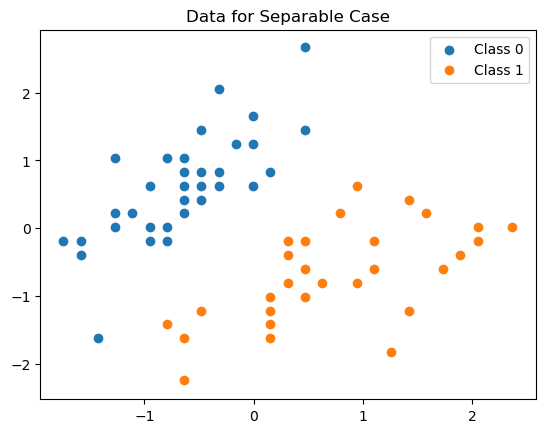

(Any[[-135.135 123.127; -53.4154 63.2801; -53.3125 47.1875; -116.411 102.095], [-18.5896 13.7669 -10.3359 -47.9914]], Any[[3.86752, -9.5326, 4.03674, 10.4677], [36.7368]])

In [17]:
#---------------------------------------------------------
# Use LBFGS to optimize the MLP loss
#---------------------------------------------------------
function train(trainfeatures::Array{Float64,2}, trainlabels::Array{Float64,1}, netdefinition::Array{Int, 1})
    # initialize network parameters
    W_init, b_init = initWeights(netdefinition, 0.01, 0.001)
    theta_init = weightsToTheta(W_init, b_init)
    
    # define loss function and gradient
    loss(theta) = nnloss(theta, trainfeatures, trainlabels, netdefinition)
    lossgrad!(storage, theta) = nnlossgrad(storage, theta, trainfeatures, trainlabels, netdefinition)
    
    # perform optimization
    theta_opt = Optim.minimizer(optimize(loss, lossgrad!, theta_init, LBFGS()))
    Ws, bs = thetaToWeights(theta_opt, netdefinition)
  return Ws::Vector{Any},bs::Vector{Any}
end

# make results reproducable
Random.seed!(10)

# LINEAR SEPARABLE DATA
# load data
features,labels = loaddata("separable.jld2")

# show data points
showbefore(features,labels)
title("Data for Separable Case")

# train MLP
Ws,bs = train(features,labels, [2,4,1])

In [18]:
#---------------------------------------------------------
# Predict the classes of the given data points using Ws and Bs.
# p, N x 1 array of Array{Float,2}, contains the output class scores (continuous value) for each input feature.
# c, N x 1 array of Array{Float,2}, contains the output class label (either 0 or 1) for each input feature.
#---------------------------------------------------------
function predict(X::Array{Float64,2}, Ws::Vector{Any}, bs::Vector{Any})
    
    # do forward pass
    z = X'
    for i in 1:length(Ws)
        W = Ws[i]
        b = bs[i]
        a = W * z .+ b
        z = sigmoid(a)
    end
    
    p = collect(z')
    c = round.(p)

  return p::Array{Float64,2}, c::Array{Float64,2}
end

predict (generic function with 1 method)

In [19]:
#---------------------------------------------------------
# A helper function which concatenates weights and biases into a variable theta
#---------------------------------------------------------
function weightsToTheta(Ws::Vector{Any}, bs::Vector{Any})
    # helper function to flatten an array
    flatten(x) = reshape(x, length(x))
    
    # concatenate weights and biases [W b], then flatten
    theta_list = [flatten([Ws[i] bs[i]]) for i in 1:length(Ws)]
    
    # concatenate all thetas horizontally
    theta = vcat(theta_list...)
  return theta::Vector{Float64}
end

weightsToTheta (generic function with 1 method)

In [20]:
#---------------------------------------------------------
# A helper function which decomposes and reshapes weights and biases from the variable theta
#---------------------------------------------------------
function thetaToWeights(theta::Vector{Float64}, netdefinition::Array{Int,1})
    # initialize empty lists for W and b
    Ws = Vector()
    bs = Vector()
    
    # start with the first element in theta
    start_idx = 1
    
    # for each layer
    for i = 1:(length(netdefinition) - 1)
        # compute the last element of the current concatenated [W b]
        end_idx = start_idx - 1 + (netdefinition[i] + 1) * netdefinition[i+1]
    
        # get the current [W b] element
        Wb = theta[start_idx:end_idx]
        
        # undo the reshaping
        Wb = reshape(Wb, netdefinition[i + 1], netdefinition[i] + 1) 
        
        # undo the concatenation of W and b
        W = Wb[:,1:end-1]
        b = Wb[:,end]
        
        # append to list of Ws and bs
        push!(Ws,W)
        push!(bs,b)
        
        # update start index
        start_idx = end_idx + 1
    end

  return Ws::Vector{Any}, bs::Vector{Any}
end

thetaToWeights (generic function with 1 method)

In [21]:
#---------------------------------------------------------
# Initialize weights and biases from Gaussian distributions
#---------------------------------------------------------
function initWeights(netdefinition::Array{Int,1}, sigmaW::Float64, sigmaB::Float64)
    # initialize empty lists
    Ws = Vector()
    bs = Vector()
    # for each layer
    for i in 1:length(netdefinition)-1
        # randomly sample W and b
        W = randn(netdefinition[i+1], netdefinition[i]) * sigmaW
        b = randn(netdefinition[i+1]) * sigmaB
        # append to lists
        push!(Ws, W)
        push!(bs, b)
    end
  return Ws::Vector{Any}, bs::Vector{Any}
end

initWeights (generic function with 1 method)

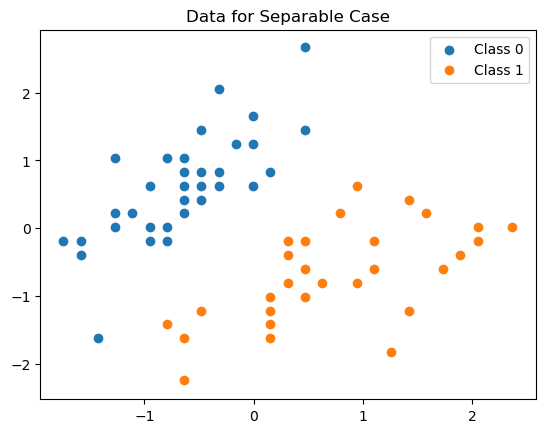

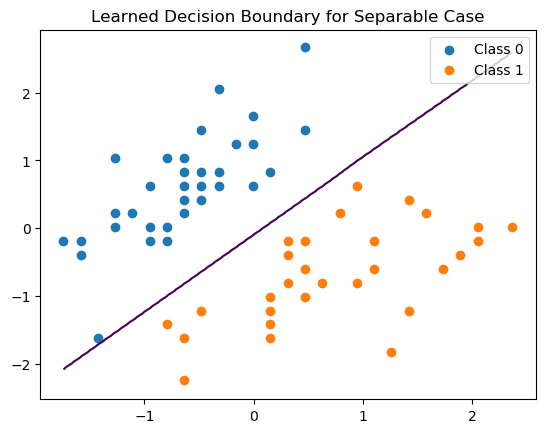

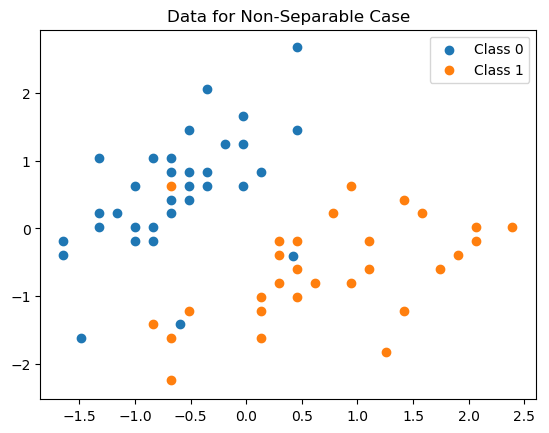

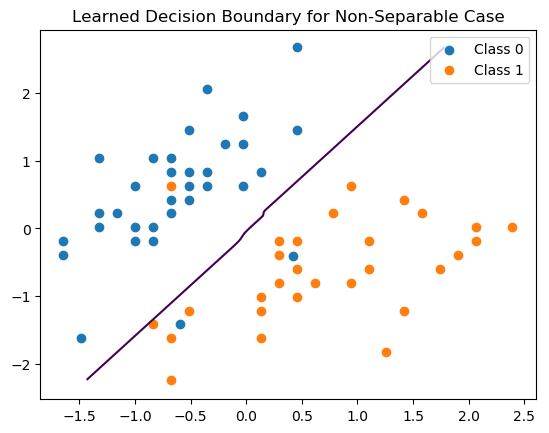

Training Error Rate: 2.5%
Testing Error Rate: 1.67%


In [143]:
# Problem 2: Multilayer Perceptron

function problem2()
  # make results reproducable
  Random.seed!(10)

  # LINEAR SEPARABLE DATA
  # load data
  features,labels = loaddata("separable.jld2")

  # show data points
  showbefore(features,labels)
  title("Data for Separable Case")

  # train MLP
  Ws,bs = train(features,labels, [2,4,1])

  # show optimum and plot decision boundary
  showafter(features,labels,Ws,bs)
  title("Learned Decision Boundary for Separable Case")


  ## LINEAR NON-SEPARABLE DATA
  # load data
  features2,labels2 = loaddata("nonseparable.jld2")

  # show data points
  showbefore(features2,labels2)
  title("Data for Non-Separable Case")

  # train MLP
  Ws,bs = train(features2,labels2, [2,4,1])

  # show optimum and plot decision boundary
  showafter(features2,labels2,Ws, bs)
  title("Learned Decision Boundary for Non-Separable Case")

  # PLANE-BIKE-CLASSIFICATION FROM PROBLEM 2
  # load data
  trainfeatures,trainlabels = loaddata("imgstrain.jld2")
  testfeatures,testlabels = loaddata("imgstest.jld2")

  # train MLP and predict classes
  Ws,bs = train(trainfeatures,trainlabels, [50,40,30,1])
  _,trainpredictions = predict(trainfeatures, Ws, bs)
  _,testpredictions = predict(testfeatures, Ws, bs)

  # show error
  trainerror = sum(trainpredictions.!=trainlabels)/length(trainlabels)
  testerror = sum(testpredictions.!=testlabels)/length(testlabels)
  println("Training Error Rate: $(round(100*trainerror,digits=2))%")
  println("Testing Error Rate: $(round(100*testerror,digits=2))%")

  return
end

problem2()

# Try different architectures
Here's a function that computes training and test errors for a given architecture and a given seed. I'm using DataFrames.jl to keep track of the results, so if you don't have it installed, run Pkg.add("DataFrames") first.

In [ ]:
function try_architectures(net, seed)
  Random.seed!(seed)
  # PLANE-BIKE-CLASSIFICATION FROM PROBLEM 2
  # load data
  trainfeatures,trainlabels = loaddata("imgstrain.jld2")
  testfeatures,testlabels = loaddata("imgstest.jld2")

  # train MLP and predict classes
  Ws,bs = train(trainfeatures,trainlabels, net)
  _,trainpredictions = predict(trainfeatures, Ws, bs)
  _,testpredictions = predict(testfeatures, Ws, bs)

  # show error
  trainerror = sum(trainpredictions.!=trainlabels)/length(trainlabels)
  testerror = sum(testpredictions.!=testlabels)/length(testlabels)

  return trainerror, testerror
end

## Vary first hidden layer, keep second hidden layer fixed

In [139]:
using DataFrames

df = DataFrame(Seed = Int[], Neurons = Int[], TrainError = Float64[], TestError = Float64[])

neurons = collect(5:5:100)
for seed in 1:5
    for i in 1:length(neurons)
        try
            trainerror, testerror = try_architectures([50,neurons[i],30,1], seed)
            push!(df, (seed, neurons[i], trainerror, testerror))
        catch
            push!(df, (seed, neurons[i], NaN, NaN))
        end

    end
end

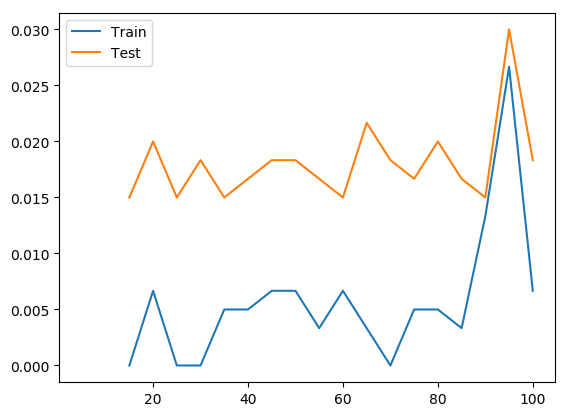

PyObject <matplotlib.legend.Legend object at 0x7f52203347f0>

In [140]:
mean_df = by(df, :Neurons, MeanTrainError = :TrainError => mean, MeanTestError = :TestError => mean)
plot(mean_df[:Neurons], mean_df[:MeanTrainError], label="Train")
plot(mean_df[:Neurons], mean_df[:MeanTestError], label="Test")
legend()

## Vary second hidden layer, keep first hidden layer fixed

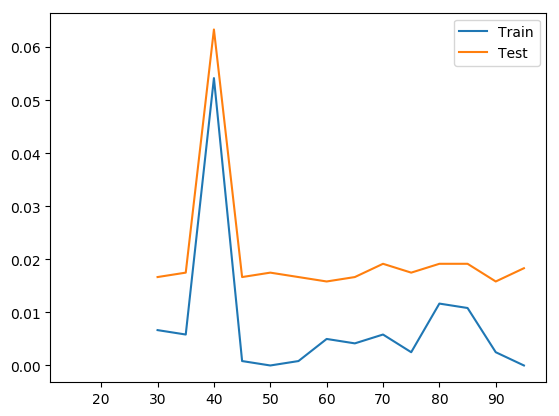

PyObject <matplotlib.legend.Legend object at 0x7f52160135f8>

In [141]:
df2 = DataFrame(Seed = Int[], Neurons = Int[], TrainError = Float64[], TestError = Float64[])

neurons = collect(5:5:100)
for seed in 1:10
    for i in 1:length(neurons)
        try
            trainerror, testerror = try_architectures([50,40,neurons[i],1], seed)
            push!(df2, (seed, neurons[i], trainerror, testerror))
        catch
            push!(df2, (seed, neurons[i], NaN, NaN))
        end

    end
end
    
mean_df2 = by(df2, :Neurons, MeanTrainError = :TrainError => mean, MeanTestError = :TestError => mean)
plot(mean_df2[:Neurons], mean_df2[:MeanTrainError], label="Train")
plot(mean_df2[:Neurons], mean_df2[:MeanTestError], label="Test")
legend()

## Vary number of hidden layers
Here I'm simply adding additional layers with 40 neurons. Starting with a [50,30,1] network, I add layers with 40 hidden units one after another, so that :Layers in the result is the number of hidden layers and for each number of layers >1 we have 1 additional hidden layer with 40 neurons.

In [168]:
net = [50,30,1]
insert!(net, 2, 40)

4-element Array{Int64,1}:
 50
 40
 30
  1

In [169]:
df3 = DataFrame(Seed = Int[], Layers = Int[], TrainError = Float64[], TestError = Float64[])


for seed in 1:10
    
    net = [50,30,1]
    for i in 1:6
        try
            trainerror, testerror = try_architectures(net, seed)
            push!(df3, (seed, i, trainerror, testerror))
        catch
            push!(df3, (seed, i, NaN, NaN))
        end
        insert!(net, 2, 40)
    end
end
    
mean_df3 = by(dropmissing(df3), :Layers, MeanTrainError = :TrainError => mean, MeanTestError = :TestError => mean)


,Layers,MeanTrainError,MeanTestError
,Int64,Float64,Float64
1,1,0.0,0.02
2,2,0.00666667,0.0166667
3,3,0.0133333,0.0291667
4,4,0.441667,0.441667
5,5,0.441667,0.441667
6,6,0.441667,0.441667


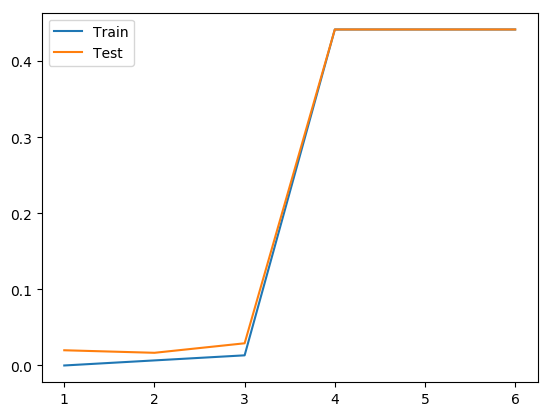

PyObject <matplotlib.legend.Legend object at 0x7f5215bbb470>

In [170]:
plot(mean_df3[:Layers], mean_df3[:MeanTrainError], label="Train")
plot(mean_df3[:Layers], mean_df3[:MeanTestError], label="Test")
legend()